This notebook shows a simple end-to-end flow: we load a poster, run a trained ResNet model to get a neural aesthetic score, compute basic design metrics using OpenCV, and combine both to produce a final aesthetic rating. Grad-CAM is shown to visualize what the model focuses on, and a loss curve is included to show that the baseline was actually trained. Each code block just demonstrates one clean stage of the pipeline — input → model → design metrics → fusion → explainability.

(np.float64(-0.5), np.float64(1076.5), np.float64(1078.5), np.float64(-0.5))

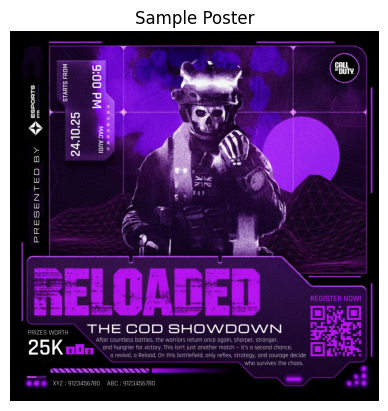

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "./data/ava_subset/images/poster2.png"

img = Image.open(img_path).convert("RGB")

plt.imshow(img)
plt.title("Sample Poster")
plt.axis("off")


In [16]:
import torch
import torch.nn as nn
from torchvision import models, transforms

# Architecture matching training script
def get_model():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 1)
    return model

# Load model
model = get_model()
state_dict = torch.load("./results/resnet18_final.pt", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Prepare tensor
input_tensor = transform(img).unsqueeze(0)

# Predict
with torch.no_grad():
    cnn_score = model(input_tensor).item()

print("CNN Score:", cnn_score)


CNN Score: 1.568573236465454


In [17]:
import sys, importlib

sys.path.append("./scripts")

if "design_metrics" in sys.modules:
    del sys.modules["design_metrics"]

import design_metrics
importlib.reload(design_metrics)

from design_metrics import compute_all_design_metrics

# Running design metric computation
design_score, details = compute_all_design_metrics(img)

print("Design Score:", design_score)
print("\nDetailed Metrics:", details)


Design Score: 0.9999961899784102

Detailed Metrics: {'contrast': 0.9999999995269131, 'clutter': 0.9999827804254364, 'color_harmony': 0.9999999996505886, 'balance': 0.999999972300194, 'whitespace': 0.999998197988919}


Final Aesthetic Score: 1.3411424178706366


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

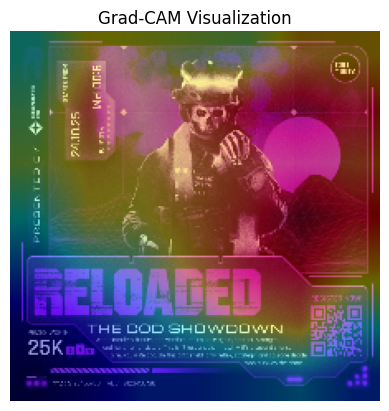

In [18]:
alpha = 0.6
final_score = alpha * cnn_score + (1 - alpha) * design_score

print("Final Aesthetic Score:", final_score)

# Grad-CAM output
gradcam_path = "./results/gradcam_overlay.png"  

gradcam_img = Image.open(gradcam_path)
plt.imshow(gradcam_img)
plt.title("Grad-CAM Visualization")
plt.axis("off")


(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

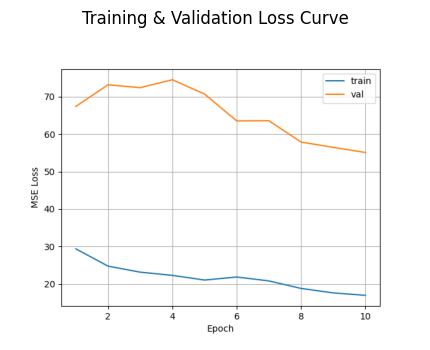

In [19]:
import matplotlib.pyplot as plt
from PIL import Image

loss_curve_path = "./results/loss_curve.png"

loss_img = Image.open(loss_curve_path)

plt.figure(figsize=(6,4))
plt.imshow(loss_img)
plt.title("Training & Validation Loss Curve")
plt.axis("off")
